In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from shortfall.sim import Simulator, SimConfig
from shortfall.miners.repay_proportional import RepayProportionalShortfallMinerState
from shortfall.miners.burn import BurnShortfallMinerState
from shortfall.miners.repay_ratchet import RepayRatchetShortfallMinerState
from shortfall.miners.base import BaseMinerState
from shortfall.network import *
from shortfall.strategy import *
from shortfall.consts import *
import shortfall.gradient.base_cost_models as bcm

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl

from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle
from tqdm.auto import tqdm

In [3]:
days = 3 * YEAR + 1
stats_interval = DAY

In [4]:
def get_burn_stats(shortfall_pct, power, shortfall_pct_pow, take_shortfall=True, token_lease_fee=0.2):
    """
    This function executes the burn variant of shortfall. Parameters:
     shortfall_pct - the amount of shortfall to take
     shortfall_pct_pow - this is the exponent which controls how fast the shortfall is repaid to the protocol
     take_shortfall - True if taking shortfall, can set to False otherwise
     token_lease_fee - cost to lease tokens

    ** My understanding ** 
    Initially, the intent was to evaluate shortfall in the following way: a miner
    takes a certain shortfall percentage, and borrows the remainder of the tokens needed
    from an external source (costs associated w/ that borrowing are dictated by the token_lease_fee argument).
    This implies no upfront pledge from an SP onboarding power (from their own wallet).

    ==> Question: is the token_lease_fee a static amount? I think so based on my inspection of the code.
    
    I would like to expand this to the scenario where an SP takes a certain % of shortfall,
    and puts the remaining pledge from their personal wallet. To enable this scenario,
    I configure the miner strategy as follows:
      - miner_balance = 0
      - token_lease_fee = 0  # implies no fee for leasing, so effectively free (coming from wallet?)
      - max_shortfall_fraction = the % of shortfall to take
    @anorth - can you comment if this sounds correct in terms of simulation strategy?
    I believe this works b/c I am using the power_limited scenario, based on my tracing of the code.
    """
    network = dataclasses.replace(MAINNET_APR_2023,
        token_lease_fee=token_lease_fee,
        reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
        initial_pledge_projection_period_days=20.0,
        supply_lock_target=0.3
    )
    
    burn_miner_factory = BurnShortfallMinerState.factory(balance=0, 
                                                         max_shortfall_fraction=shortfall_pct,
                                                         shortfall_take_rate_exponent=shortfall_pct_pow)

    burn_pl_cfg = SimConfig(
        network=network,
        strategy=StrategyConfig.power_limited(power * TIBIBYTE / EXBIBYTE, days, take_shortfall),
        miner_factory=burn_miner_factory,
    )
    stats_burn = Simulator(burn_pl_cfg).run_all(days, stats_interval)
    return stats_burn

In [5]:
def get_income(df):
    return df['net_equity']

In [6]:
# parameters - max_shortfall, shortfall_pct_pow
# TODO: explain intuitively what you are optimizing for

sampling_rate = 30  # sampling rate of the income curve
power = 50  # doesn't matter since we normalize

def compute_loss(x):
    max_shortfall_pct = x[0]
    shortfall_pct_pow = x[1]

    burn_income_stats = get_burn_stats(max_shortfall_pct, power, shortfall_pct_pow, take_shortfall=True, token_lease_fee=0.0)
    # 0.2 is a noop since we don't take shortfall in the baseline
    base_income_stats = get_burn_stats(0.2, power, 0.2, take_shortfall=False, token_lease_fee=0.2)
    
    # sample the income trajectory every N days
    indices = np.arange(sampling_rate, len(burn_income_stats), sampling_rate)

    income_burn = jnp.asarray([burn_income_stats[ii]['net_equity'] for ii in indices])
    income_base = jnp.asarray([base_income_stats[ii]['net_equity'] for ii in indices])

    burn_target = income_base * 0.9
    burn_actual = income_burn

    mse_loss = jnp.mean(jnp.power(burn_target - burn_actual, 2)) / len(indices)

    return mse_loss

In [10]:
max_shortfall_pct_vec = np.arange(0.1,0.5+0.05, 0.05)
shortfall_pct_pow_vec = np.arange(0.1,0.9+0.05,0.05)

loss_surface = np.zeros((len(max_shortfall_pct_vec), len(shortfall_pct_pow_vec)))
pbar = tqdm(total=loss_surface.size)
for ii, max_shortfall_pct in enumerate(max_shortfall_pct_vec):
    for jj, shortfall_pct_pow in enumerate(shortfall_pct_pow_vec):
        x_in = jnp.asarray([max_shortfall_pct, shortfall_pct_pow])
        loss_surface[ii,jj] = compute_loss(x_in)
        pbar.update(1)

  0%|          | 0/153 [00:00<?, ?it/s]

In [7]:
init_max_shortfall_frac = 0.1
init_shortfall_pct_pow = 0.1

x = jnp.asarray([init_max_shortfall_frac, init_shortfall_pct_pow])
loss_grad = jax.value_and_grad(compute_loss, argnums=0)

n_iter = 10
alpha = 1e-4
x_track = []
loss_track = []
x_track.append(np.asarray(x))
for i in range(n_iter):
    loss, grads = loss_grad(x)
    x = x - alpha * grads
    
    loss_track.append(np.asarray(loss))
    x_track.append(np.asarray(x))
    print(i, loss, grads, x)

0 101.48666 [-976.36633     -1.7758529] [0.19763663 0.10017759]
1 34.31336 [-413.8797    -16.436901] [0.23902461 0.10182127]
2 21.979721 [-192.60753  -25.68914] [0.25828537 0.10439019]
3 19.187016 [-88.96916  -26.657747] [0.2671823  0.10705596]
4 18.543371 [-39.855896 -26.186789] [0.27116787 0.10967464]
5 18.360556 [-17.759558 -25.750605] [0.27294382 0.1122497 ]
6 18.27198 [ -7.8760953 -25.362621 ] [0.27373144 0.11478596]
7 18.18737 [-18.09718  -34.978207] [0.27554116 0.11828379]
8 18.037893 [-10.26427 -35.42655] [0.27656758 0.12182644]
9 17.904741 [ -5.4651814 -35.11751  ] [0.2771141 0.1253382]


In [8]:
def closest_idx(x, x0):
    ii = np.argmin(np.abs(x-x0))
    return ii

In [26]:
np.flipud(ll/np.max(ll))

array([0.17642459, 0.1777366 , 0.17920947, 0.18004318, 0.18091596,
       0.18271733, 0.18905949, 0.21657745, 0.33810709, 1.        ])

<IPython.core.display.Javascript object>


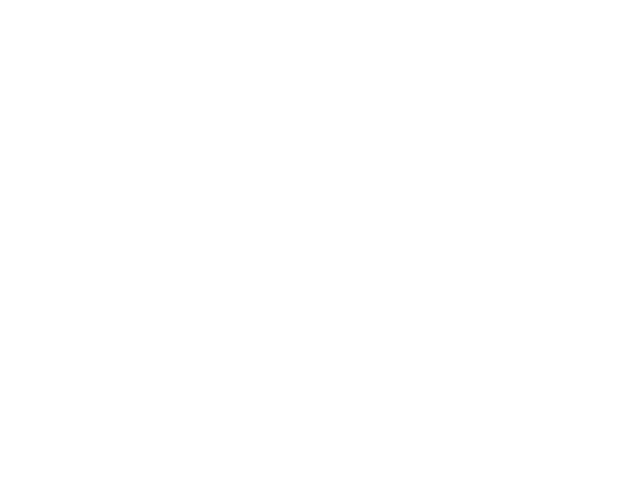

<IPython.core.display.Javascript object>


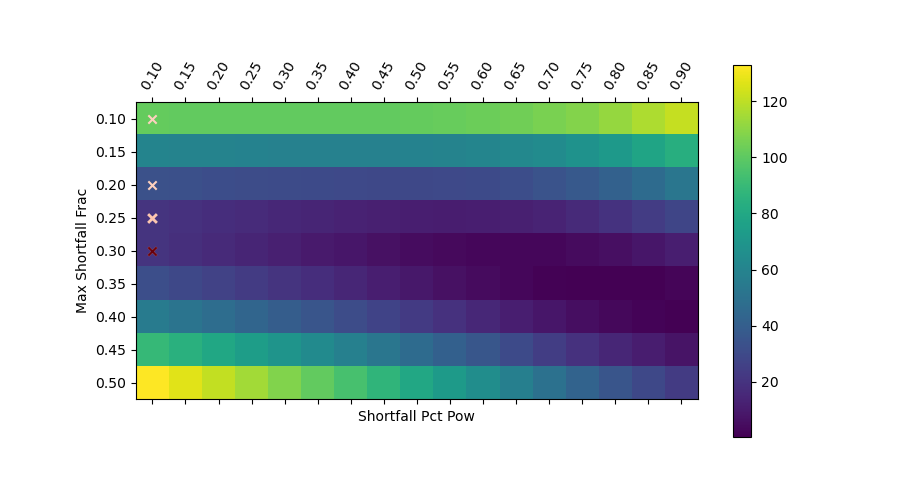

0
1
2
3
4
5
6
7
8
9
10


IndexError: index 10 is out of bounds for axis 0 with size 10

In [27]:
plt.figure()
plt.matshow(loss_surface)
xt = ['%0.02f' % (x,) for x in shortfall_pct_pow_vec]
yt = ['%0.02f' % (x,) for x in max_shortfall_pct_vec]
plt.xticks(range(len(xt)))
plt.yticks(range(len(yt)))
ax = plt.gca()
ax.set_xticklabels(xt, rotation=60)
ax.set_yticklabels(yt)
ax.set_xlabel('Shortfall Pct Pow')
ax.set_ylabel('Max Shortfall Frac')
plt.colorbar()

ll = np.asarray([float(x) for x in loss_track])

cmap=mpl.colormaps['Reds']
cmap_access_vec = np.flipud(ll/np.max(ll))
for ii, x in enumerate(x_track):
    print(ii)
    # translate x backwards
    x_idx = closest_idx(max_shortfall_pct_vec, x[0])
    y_idx = closest_idx(shortfall_pct_pow_vec, x[1])
#     print(x, x_idx, y_idx)
    # max_shortfall_pct_vec = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5])
    # shortfall_pct_pow_vec = np.asarray([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.scatter(y_idx, x_idx, marker='x', color=cmap(cmap_access_vec[ii]))